Nowadays, determining the right price is crucial for a business. If the price is set too low, customers will hesitate to buy due to fear of poor quality. However, if it's too high, customers will also be reluctant to buy due to the high price. This is related to price elasticity.

Price elasticity is a measure of how responsive the demand for a product is to changes in its price

The goal of this project is to determine the right price for a product using Generalized Additive Models (GAM)

The following is an explanation of the dataset
- Segment: Which segment is the company that bought the product
- Product: Product name
- discount: Level of discount received on the purchase
- Quantity: Quantity purchased
- price: Unit price
- Sales: Unit price * Quantity

Import Data

In [1]:
# Data Wrangling
import pandas as pd
import numpy as np

# Data Visualization
from plotnine import *
import plotly_express as px

# Modeling
from sklearn.preprocessing import LabelEncoder
from pygam import GAM, ExpectileGAM, s, l, f
import statsmodels.api as sm

import warnings
warnings.simplefilter('ignore')

Load Data

In [24]:
# load dataset
file_ = r'C:\Users\ACER\Downloads\price_optimization.xlsx'
df = pd.read_excel(file_)

print(f'Data Shape: {df.shape}')

# View data head
df.sample(3)

Data Shape: (2800, 10)


,Segment,Product,discount,Quantity,price,Sales,Date,mth_num,mth_name,yr
617,Government,Carretera,Medium,936.0,17.750956,16614.89444,2014-12-01,12,December,2014
1963,Government,Velo,High,2184.0,22.413963,48952.09439,2014-10-01,10,October,2014
2599,Government,VTT,Medium,519.0,12.466838,6470.28876,2013-10-01,10,October,2013


In [25]:
df.dtypes

Segment             object
Product             object
discount            object
Quantity           float64
price              float64
Sales              float64
Date        datetime64[ns]
mth_num              int64
mth_name            object
yr                   int64
dtype: object

In [26]:
# There are NAs only in `discount`, when there is no discount.
# We will replace those NAs with "No Discount"
df.fillna("No Discount", inplace=True)

In [27]:
# Statistical description
df.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Segment,2800,5,Government,1200,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Product,2800,6,Paseo,808,NaN,NaN,NaN,NaN,NaN,NaN,NaN
discount,2800,4,High,980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,2800.0,NaN,NaN,NaN,1011.963594,145.0,346.0,662.632642,1254.469773,7979.0,1061.547181
price,2800.0,NaN,NaN,NaN,22.576275,1.0,9.440982,18.529493,37.216872,51.97611,14.726118
Sales,2800.0,NaN,NaN,NaN,16775.314162,889.086541,6380.881285,11345.658475,19390.813627,127546.4141,15857.64593
Date,2800,NaN,NaN,NaN,2014-04-28 21:36:00,2013-09-01 00:00:00,2013-12-24 06:00:00,2014-05-16 12:00:00,2014-09-08 12:00:00,2014-12-01 00:00:00,NaN
mth_num,2800.0,NaN,NaN,NaN,7.9,1.0,5.75,9.0,10.25,12.0,3.37551
mth_name,2800,12,October,560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yr,2800.0,NaN,NaN,NaN,2013.75,2013.0,2013.75,2014.0,2014.0,2014.0,0.43309


Takeaways from the data:
- No major concerns, and no apparent errors in the data
- The biggest variances are in Sales and Quantity numbers, which are skewed to the right
- The top product is Paseo
- The top segment is the Government

EDA

In [28]:
# Exploring the relationship between price and units sold
fig = px.scatter(
    df, 
    x= 'price', y = 'Quantity',
    color= 'Product',
    opacity=0.5,
    trendline='lowess',
    # trendline_color_override='blue',
    title= 'Price vs Quantity Analysis',
    width=900,
    height=500,
    color_discrete_sequence=px.colors.qualitative.G10
).update_traces(
    marker= dict(size=7),
    hoverlabel= dict(font= dict(size=10))
).update_xaxes(
    title_text = 'Price',
    tickfont= dict(size=10)
).update_yaxes(
    title_text = 'Quantity Sold',
    tickfont= dict(size=10)
)

# Show figure
fig

From the data above:
- Looking at our top product, Paseo, notice that the quantities are dropping as the price goes up, with some random activity in the middle
- Another product, Amarilla, has an apparent high elasticity to the price, given that the demand changes drastically as the price goes up

In [29]:
# Calculating Price-Demand elasticity
(
    df
    .groupby('Product')
    .agg({'price': ['max', 'min'],
          'Quantity': ['max', 'min'],
          'Product':'count'})
    .reset_index()
    .pipe(lambda d: d.set_axis(['Product', 'price_max', 'price_min', 'qty_max', 'qty_min', 'obs_count'], axis=1))
    .assign(pct_change_price=lambda d: (d['price_max'] - d['price_min']) / d['price_min'] * 100,
            pct_change_qty  =lambda d: (d['qty_max'] - d['qty_min']) / d['qty_min'] * 100)
    .assign(
         ratio=lambda d: d['pct_change_qty'] / d['pct_change_price']) # demand elasticity
    .sort_values('ratio', ascending=False)
)

,Product,price_max,price_min,qty_max,qty_min,obs_count,pct_change_price,pct_change_qty,ratio
3,Paseo,51.976110,31.286696,2268.023316,145.0,808,66.128470,1464.154011,22.141054
5,Velo,36.946751,19.106243,2489.000000,197.0,436,93.375282,1163.451777,12.459955
0,Amarilla,14.673598,3.143178,4384.878030,215.0,376,366.839554,1939.478153,5.286993
4,VTT,26.950991,5.001823,2151.237279,165.0,436,438.823349,1203.780169,2.743200
2,Montana,16.994412,1.000000,7979.000000,213.0,372,1599.441152,3646.009390,2.279552
1,Carretera,24.592797,1.294622,7913.000000,209.0,372,1799.612407,3686.124402,2.048288


Amarilla has one of the highest price elasticities

In [30]:
# Exploring the relationship between price and units sold conditioned on the Discounts
fig = px.scatter(
    df, 
    x= 'price', y = 'Quantity',
    color= 'discount',
    facet_col= 'Product',
    facet_col_wrap=2,
    facet_col_spacing=0.1,
    facet_row_spacing=0.15,
    opacity=0.5,
    trendline='lowess',
    title= 'Price vs Quantity | Discount Analysis',
    width=1000,
    height=800,
    color_discrete_sequence=px.colors.qualitative.G10
).update_traces(
    marker= dict(size=7),
    hoverlabel= dict(font= dict(size=10))
).update_xaxes(
    title_text = 'Price',
    tickfont= dict(size=10)
).update_yaxes(
    title_text = 'Quantity Sold',
    tickfont= dict(size=10)
)

fig.for_each_yaxis(lambda yaxis: yaxis.update(showticklabels=True)) #show ticks
fig.for_each_xaxis(lambda xaxis: xaxis.update(showticklabels=True)) #show ticks
fig.update_yaxes(matches=None) # don't share y axis
fig.update_xaxes(matches=None) # don't share x axis

# Show figure
fig


- With a High Discount rate usually the trend goes down as the price increases. That means that the level of discount impacts more at that level

Modelling

One Hot Encoding it (binarization 1s and 0s of the products and discounts)

In [31]:
# Encoding the data
df_encoded = df.copy()

# One Hot Encoding the events and products
df_encoded = pd.get_dummies(df_encoded,
                            columns= ['discount', 'Product'],
                            drop_first=False)

# Get column names Events
colnames_event = df_encoded.columns[df_encoded.columns.str.startswith('discount')].tolist()
# From boolean to integer
df_encoded[colnames_event] = df_encoded[colnames_event].astype(int)

# Get column names Products
colnames_product = df_encoded.columns[df_encoded.columns.str.startswith('Product')].tolist()
# From boolean to integer
df_encoded[colnames_product] = df_encoded[colnames_product].astype(int)

In [32]:
df_encoded.drop(['Date', 'mth_num', 'mth_name', 'yr', 'Segment'], axis=1).head(2)

,Quantity,price,Sales,discount_High,discount_Low,discount_Medium,discount_No Discount,Product_Amarilla,Product_Carretera,Product_Montana,Product_Paseo,Product_VTT,Product_Velo
0,4178.151185,3.462242,14465.77121,1,0,0,0,1,0,0,0,0,0
1,3469.852007,4.166472,14457.04249,1,0,0,0,1,0,0,0,0,0


Then, we will input that table into an OLS() model from statsmodels. The predictors are the binary columns for discounts and products, while the target is the quantity sold.

In [33]:
# X & y for modeling
X = df_encoded[['price'] + colnames_event + colnames_product]
X = sm.add_constant(X) # adding intercept
y = df_encoded['Quantity']

# Model Fit
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     345.3
Date:                Thu, 30 Oct 2025   Prob (F-statistic):               0.00
Time:                        04:36:11   Log-Likelihood:                -22433.
No. Observations:                2800   AIC:                         4.489e+04
Df Residuals:                    2790   BIC:                         4.495e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  780.8930 

In [34]:
# Getting the Effects (parameters) from each variable
params_df = pd.DataFrame(model.params).T
params_df

,const,price,discount_High,discount_Low,discount_Medium,discount_No Discount,Product_Amarilla,Product_Carretera,Product_Montana,Product_Paseo,Product_VTT,Product_Velo
0,780.893033,-11.596438,1206.942656,-219.975466,139.009688,-345.083846,724.006837,265.291095,104.32785,8.745538,-321.262391,-0.215897


In [36]:
# Estimating the price effects ratio
(params_df['discount_High'] + params_df['const']) / (params_df['discount_No Discount'] + params_df['const'])

0    4.561252
dtype: float64

In [37]:
(params_df['discount_High'] + params_df['const'])

0    1987.835689
dtype: float64

In [38]:
(params_df['discount_No Discount'] + params_df['const'])

0    435.809187
dtype: float64

Price Optimization

GAM is an additive modeling technique where the impact of the predictive variables is captured through smooth functions

In [39]:
# Filtering data
data_filtered = df.query('discount == "No Discount"')

# List of products in our data
unique_prod = data_filtered['Product'].unique()

# Create an empty dataframe to store results
all_gam_results = pd.DataFrame()

Then, we will loop through each product’s price and Quantity and submit them to the ExpectileGAM() model, getting the predictions to the median (50% percentile), as well as for the lower (2.5% percentile) and upper (97.5% percentile) bands. We store all of that in a data frame

In [40]:
# Loop through products
for product in unique_prod:
    # Filter for current product
    product_data = data_filtered.query('Product == @product')

    # Predictors & target split
    X = product_data[['price']]
    y = product_data['Quantity']

    # List of quantiles for modeling
    quantiles = [0.025, 0.5, 0.975]
    gam_results = {}

    # Fit the GAM model
    for q in quantiles:
        gam = ExpectileGAM(s(0), expectile=q) # instance the model
        gam.fit(X,y) #fit
        gam_results[f'pred_{q}'] = gam.predict(X) #predict for that quantile
        print(q, "|", product, "|", gam.deviance_residuals(X,y).mean())
    print("-----------\n")

    # Store the results in a DF
    predictions_gam = pd.DataFrame(gam_results).set_index(X.index)

    # Concatenate results column-wise with the original data
    predictions_gam_df = pd.concat([product_data[['price', 'Product','Quantity']], predictions_gam], axis=1)
    
    # Concatenate results row-wise
    all_gam_results = pd.concat([all_gam_results, predictions_gam_df], axis=0)

0.025 | Amarilla | 28.93160833511716
0.5 | Amarilla | 2.2312381720013263e-07
0.975 | Amarilla | -32.458615357602184
-----------

0.025 | Carretera | 25.492619077836356
0.5 | Carretera | 2.828768437268536e-07
0.975 | Carretera | -46.68953248049693
-----------

0.025 | Montana | 21.966986859588314
0.5 | Montana | 1.6986699620247235e-07
0.975 | Montana | -43.77244624907085
-----------

0.025 | Paseo | 25.211899706035037
0.5 | Paseo | 8.296440843954163e-08
0.975 | Paseo | -40.634718131772196
-----------

0.025 | Velo | 26.147643853420806
0.5 | Velo | 2.289392061324439e-07
0.975 | Velo | -39.73156922159598
-----------

0.025 | VTT | 21.06498134395044
0.5 | VTT | 1.961033362363196e-07
0.975 | VTT | -40.482847968136916
-----------



In [41]:
all_gam_results.sample(5)

,price,Product,Quantity,pred_0.025,pred_0.5,pred_0.975
2780,24.521998,VTT,165.0,166.834060,187.830888,224.926314
2798,26.557239,VTT,182.0,175.028992,194.660106,241.881496
368,13.117247,Amarilla,272.0,222.095130,256.814290,302.609455
370,13.163614,Amarilla,230.0,222.527421,256.498471,302.143597
1899,50.306839,Paseo,154.0,151.474261,177.379786,220.634738


Matplotlib is building the font cache; this may take a moment.


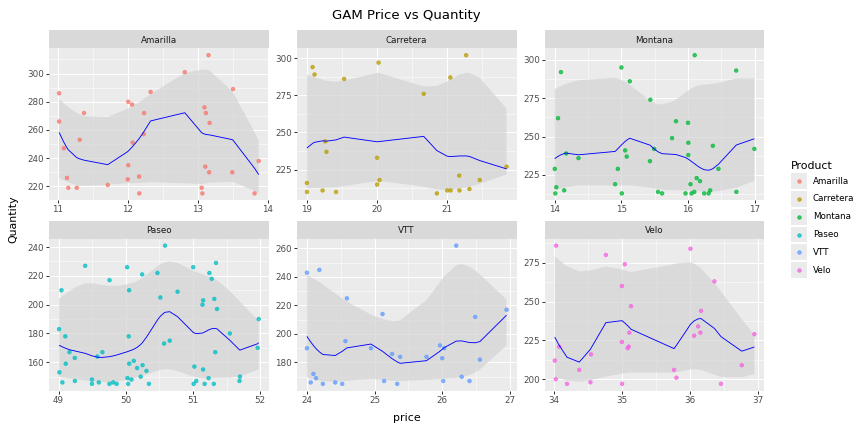

In [42]:
# Visualization of the model and prices within the bands
(ggplot(
    data = all_gam_results,
    mapping = aes(x='price', y='Quantity', color='Product', group= 'Product') ) +
    geom_ribbon(aes(ymax= 'pred_0.975', ymin= 'pred_0.025'), 
                fill='#d3d3d3', color= '#FF000000', alpha=0.7, show_legend=False) +
    geom_point(alpha=0.75) + 
    geom_line(aes(y='pred_0.5'), color='blue') +
    facet_wrap('Product', scales='free') + 
    labs(title='GAM Price vs Quantity') +
    theme(figure_size=(12,6))
)

Next, let’s calculate the predicted revenue for each price band. That is performed simply by multiplying the Quantity * pred_[price_band]

In [43]:
# Calculate Revenue for each predicted price band
for col in all_gam_results.columns:
    if col.startswith('pred'):
        all_gam_results['revenue_' + col] = all_gam_results['price'] * all_gam_results[col]

# Actual revenue
all_gam_results['revenue_actual'] = all_gam_results['price'] * all_gam_results['Quantity']

# View
all_gam_results.sample(2)

,price,Product,Quantity,pred_0.025,pred_0.5,pred_0.975,revenue_pred_0.025,revenue_pred_0.5,revenue_pred_0.975,revenue_actual
2787,25.334657,VTT,165.0,166.987866,180.425784,209.371424,4230.580227,4571.025272,5304.353114,4180.218329
1095,15.435562,Montana,274.0,216.796389,244.176700,273.220847,3346.374195,3769.004700,4217.317455,4229.344112


The next step is to filter the dataset on the maximum revenue obtained by each price band by product

In [44]:
# Calculating where the predicted median revenue is the max
best_50 = (
    all_gam_results
    .groupby('Product')
    .apply(lambda x: x[x['revenue_pred_0.5'] == x['revenue_pred_0.5'].max()].head(1))
    .reset_index(level=0, drop=True)
)

# Calculating where the predicted 97.5% percentile revenue is the max
best_975 = (
    all_gam_results
    .groupby('Product')
    .apply(lambda x: x[x['revenue_pred_0.975'] == x['revenue_pred_0.975'].max()].head(1))
    .reset_index(level=0, drop=True)
)

# Calculating where the predicted 2.5% percentile revenue is the max
best_025 = (
    all_gam_results
    .groupby('Product')
    .apply(lambda x: x[x['revenue_pred_0.025'] == x['revenue_pred_0.025'].max()].head(1))
    .reset_index(level=0, drop=True)
)

plot the resulting graphic

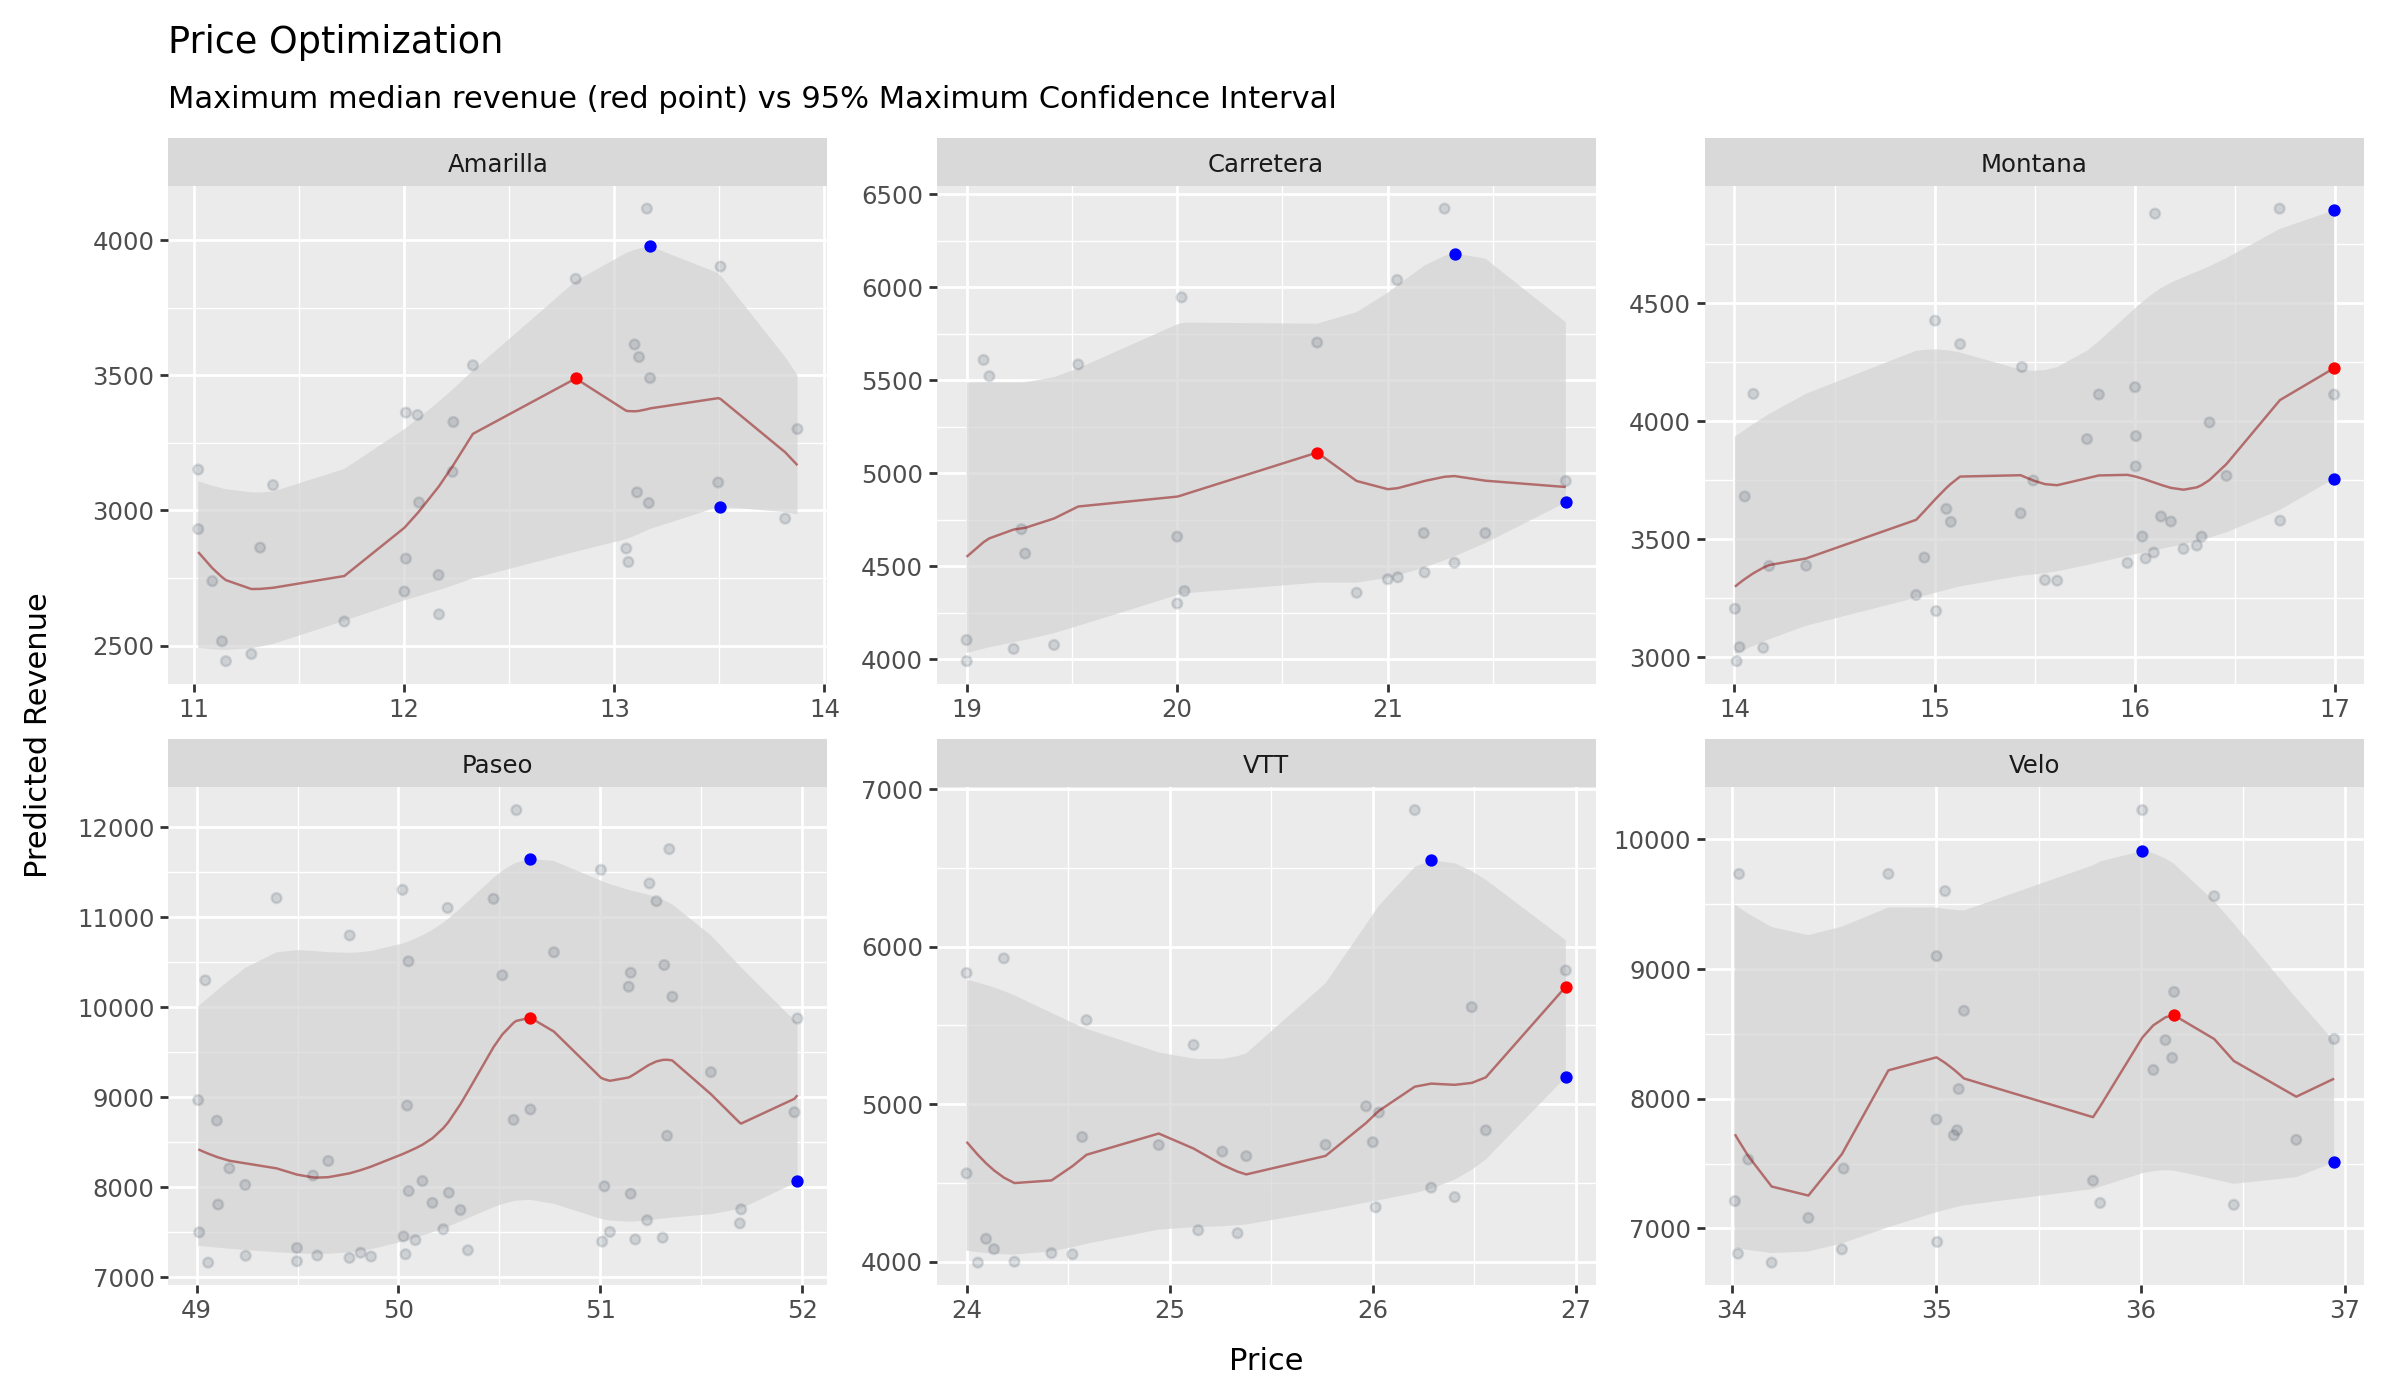

In [45]:
# Visualize the GAM Optimization Result
(ggplot(
    # Data
    data = all_gam_results,
    # Axes
    mapping = aes(x='price', y='revenue_pred_0.5', color='Product', group='Product') ) + 
# Adding the Band
geom_ribbon(aes(ymax= 'revenue_pred_0.975', ymin= 'revenue_pred_0.025'), 
                fill='#d3d3d3', color= '#FF000000', alpha=0.7, show_legend=False) +
# Adding the points
geom_point(aes(y='revenue_actual'), alpha=0.15, color="#2C3E50") +
# Adding 50th percentile line
geom_line(aes(y='revenue_pred_0.5'), alpha=0.5, color='darkred') +
# Addimg the 50th pct points
geom_point(data=best_50, color='red') + 
# Addimg the 97th pct points
geom_point(data=best_975, mapping= aes(y='revenue_pred_0.975'), color='blue') + 
# Addimg the 2.5th pct points
geom_point(data=best_025, mapping= aes(y='revenue_pred_0.025'), color='blue') + 
# Wraps by product
facet_wrap('Product', scales='free') + 
# Labels
labs(
    title='Price Optimization',
    subtitle='Maximum median revenue (red point) vs 95% Maximum Confidence Interval',
    x= 'Price',
    y= 'Predicted Revenue'
    ) +
theme(figure_size=(12,7))

)

From the data above:
- Each box is a different product.
- The gray band is the 95% confidence interval for the predicted revenue.
- The blue points are the maximum revenues at 2.5% percentile and 97.5% percentile.
- The red spot is the optimized price. In other words, it is where the median predicted revenue is at its maximum value.
- Interpreting the box for “Paseo”: The maximum predicted revenue is $9.88k @ $50.65 per unit. - If we price this product at $49, the model shows we will probably make about $8.5k in revenue, which is 14% less than the revenue at the optimized price.

In [46]:
# View optimum prices
best_50

,price,Product,Quantity,pred_0.025,pred_0.5,pred_0.975,revenue_pred_0.025,revenue_pred_0.5,revenue_pred_0.975,revenue_actual
363,12.815754,Amarilla,301.0,222.166878,272.210536,300.348296,2847.236073,3488.583283,3849.189898,3857.541972
725,20.665027,Carretera,276.0,213.523284,247.376537,280.907710,4412.464382,5112.042760,5804.965351,5703.547387
1119,16.994412,Montana,242.0,221.076855,248.594581,287.875226,3757.071058,4224.718613,4892.270060,4112.647588
1905,50.653262,Paseo,175.0,155.170906,195.125720,229.979194,7859.912594,9883.754260,11649.196415,8864.320896
2799,26.950991,VTT,217.0,191.848200,213.184543,224.114487,5170.499091,5745.534684,6040.107489,5848.365020
2359,36.163384,Velo,244.0,205.892132,239.013278,271.295617,7445.756298,8643.529032,9810.967670,8823.865787
